In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import openpyxl
import re
from tqdm import tqdm
import matplotlib.ticker as ticker

In [2]:
plt.rcParams["svg.fonttype"] = "none"

## Prepare Data

In [3]:
workbook = 'Tables_S2_S5.xlsx'
# workbook = openpyxl.load_workbook(workbook)
# sheet = workbook['articles_selected']

In [4]:
#cinvert the excel sheet to pandas dataframe 
article_data = pd.read_excel(workbook, sheet_name='Table S4')[:31]

In [5]:
article_data = article_data[["citation", "n_participants", "mean_age", "dataset", "p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association", "smallest_abs_ef", "largest_abs_ef", "psy_assessment"]]

In [6]:
structuraL_biomarkers = ["GMV", "CT", "SA", "f1", "f2", "FA", "RD", "MD", "MO", "SC", "AD", "T1w/T2w", "CD", "L1"]

In [7]:
from itertools import product

def expand_row(row, columns):
    # Split the values in each column and create a product of all combinations
    combinations = product(
        *(str(row[col]).split(', ') for col in columns)
    )
    # Create a list of dictionaries for each combination
    expanded_rows = [
        {**{col: val for col, val in zip(columns, combo)}, **row.drop(columns)}
        for combo in combinations
    ]
    return expanded_rows

# Columns to expand
columns_to_expand = ["p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association", "psy_assessment"]

# Apply the expand_row function to each row
expanded_data = [expand_row(row, columns_to_expand) for index, row in article_data.iterrows()]

# Flatten the list of lists into a single list of dictionaries
flat_data = [item for sublist in expanded_data for item in sublist]

# Convert the list of dictionaries back into a DataFrame
expanded_df = pd.DataFrame(flat_data)

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'structural') & 
                             (expanded_df['biomarker'].isin(["FC", "CBF", "FM", "BOLD"]))))]

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'functional') & 
                             (expanded_df['biomarker'].isin(structuraL_biomarkers))))]

In [8]:
def is_valid_combination(row, original_df):
    if ',' in str(row['association']):  # check that the associations and biomarkers are in the right order (as in the original spreadsheet)
        original_rows = original_df[
            (original_df['citation'] == row['citation']) &
            (original_df['n_participants'] == row['n_participants']) &
            (original_df['dataset'] == row['dataset'])
        ]

        for _, original_row in original_rows.iterrows():
            original_associations = str(original_row['association']).split(', ')
            original_biomarkers = str(original_row['biomarker']).split(', ')

            # check if the current combination exists in the original row
            if len(original_associations) == len(original_biomarkers):
                try:
                    index = original_biomarkers.index(row['biomarker'])
                    if original_associations[index] == row['association']:
                        return True
                except ValueError:
                    continue
        return False
    else:
        return True

# Apply the is_valid_combination function
expanded_df = expanded_df[expanded_df.apply(is_valid_combination, axis=1, original_df=article_data)]

In [9]:
expanded_df[expanded_df['citation'] == 'Wang et al. (2023)']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,psy_assessment,citation,n_participants,mean_age,dataset,smallest_abs_ef,largest_abs_ef
334,EXT,CBCL Total,GMV,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
335,EXT,CBCL Total,GMV,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
336,EXT,CBCL Total,GMV,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
337,EXT,CBCL Total,GMV,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
338,EXT,CBCL Total,GMV,structural,null,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
344,EXT,CBCL Total,CT,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
345,EXT,CBCL Total,CT,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
346,EXT,CBCL Total,CT,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
347,EXT,CBCL Total,CT,structural,neg,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
348,EXT,CBCL Total,CT,structural,null,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23


In [10]:
# replace functional with Functional
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('functional', 'Functional')
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('structural', 'Structural')
expanded_df['association'] = expanded_df['association'].replace('pos', 'Positive')
expanded_df['association'] = expanded_df['association'].replace('neg', 'Negative')
expanded_df['mean_age'] = expanded_df['mean_age'].astype('float')
expanded_df['association'] = expanded_df['association'].replace('nan', 'NULL')
expanded_df['association'] = expanded_df['association'].replace('null', 'NULL')

In [11]:
expanded_df[expanded_df['association'] == 'NULL']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,psy_assessment,citation,n_participants,mean_age,dataset,smallest_abs_ef,largest_abs_ef
46,INT,Bifactor,FA,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
47,INT,Bifactor,MD,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
48,ADHD,Bifactor,FA,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
49,ADHD,Bifactor,MD,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
50,conduct,Bifactor,FA,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
51,conduct,Bifactor,MD,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
231,INT,Bifactor,FM,Functional,NULL,CBCL,Reimann et al. (2023),3568.0,9.98,ABCD,NaN,NaN
232,ADHD,Bifactor,FM,Functional,NULL,CBCL,Reimann et al. (2023),3568.0,9.98,ABCD,NaN,NaN
233,conduct,Bifactor,FM,Functional,NULL,CBCL,Reimann et al. (2023),3568.0,9.98,ABCD,NaN,NaN
338,EXT,CBCL Total,GMV,Structural,NULL,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23


In [11]:
expanded_df.to_csv('expanded_article_data.csv', index=False)

In [12]:
# expanded_df = pd.read_csv('expanded_article_data.csv')

## Sorting by Effect & Data Modality

In [12]:
df_associations_biomarkers = expanded_df.drop_duplicates(subset=['citation', 'biomarker', 'biomarker_type', 'association'])

## Effects

In [14]:
df_associations_biomarkers[df_associations_biomarkers['association'] == 'NULL']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,psy_assessment,citation,n_participants,mean_age,dataset,smallest_abs_ef,largest_abs_ef
46,INT,Bifactor,FA,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
47,INT,Bifactor,MD,Structural,NULL,CBCL,Cardenas-Iniguez et al. (2022),8588.0,9.94,ABCD,NaN,NaN
231,INT,Bifactor,FM,Functional,NULL,CBCL,Reimann et al. (2023),3568.0,9.98,ABCD,NaN,NaN
338,EXT,CBCL Total,GMV,Structural,NULL,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
348,EXT,CBCL Total,CT,Structural,NULL,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
358,EXT,CBCL Total,SA,Structural,NULL,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23
383,EXT,CBCL Total,BOLD,Functional,NULL,CBCL,Wang et al. (2023),8035.0,9.85,ABCD,0.07,0.23


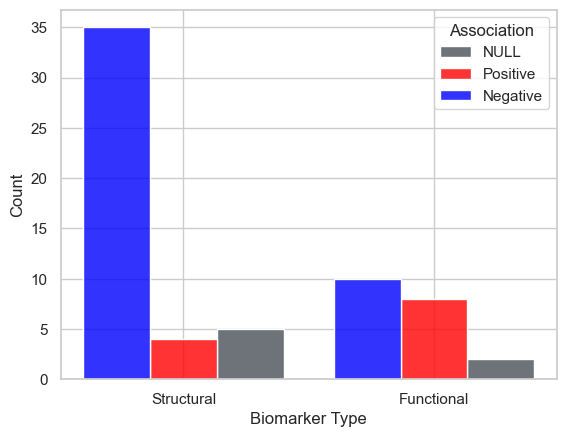

In [15]:
# sns.histplot(data=df_associations_biomarkers, x='biomarker_type', hue='association', multiple='stack', palette=['#0000fe', '#ff0000', '#495057'], shrink=0.8)

sns.set_theme(style="whitegrid")
sns.histplot(data=df_associations_biomarkers, x="biomarker_type", hue="association", multiple="dodge", shrink=.8, palette=['#0000fe', '#ff0000', '#495057'], alpha=0.8)
plt.xlabel('Biomarker Type')
plt.legend(title='Association', labels=['NULL','Positive', 'Negative'])
plt.savefig('figures/histplot_associations.svg', format = 'svg', dpi=300)


In [16]:
biomarker_colors = [
    '#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', 
    '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff', 
    '#ff5b77', '#a42400', '#001146', '#0094cc', '#e0e0e0', 
    '#000000'
]

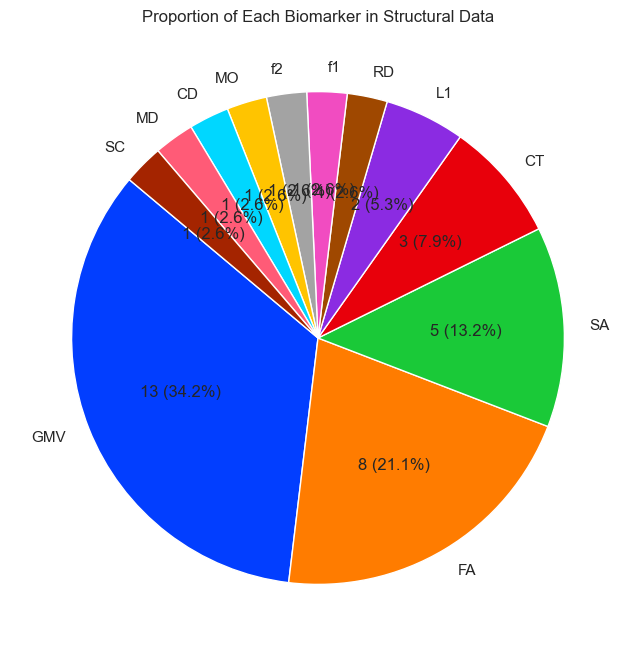

In [17]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v} ({p:.1f}%)'.format(p=pct,v=val)
    return my_format

biomarker_colors = [
    '#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', 
    '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff', 
    '#ff5b77', '#a42400', '#001146', '#0094cc', '#e0e0e0', 
    '#000000'
]

df_associations_biomarkers_str = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Structural']
df_associations_biomarkers_str = df_associations_biomarkers_str.drop_duplicates(subset=['citation', 'biomarker'])
biomarker_counts = df_associations_biomarkers_str['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Structural Data')
plt.savefig('figures/pie_plot_structural.svg', format = 'svg', dpi=300)
plt.show()

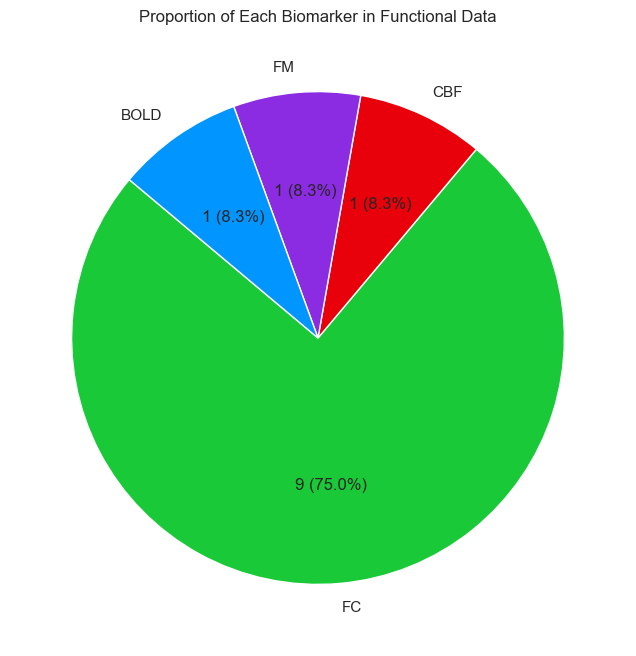

In [18]:
biomarker_colors = ['#1ac938', '#e8000b', '#8b2be2', "#0095ff"]
df_associations_biomarkers_func = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Functional']
df_associations_biomarkers_func = df_associations_biomarkers_func.drop_duplicates(subset=['citation', 'biomarker'])
biomarker_counts = df_associations_biomarkers_func['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Functional Data')
plt.savefig('figures/pie_plot_functional.svg', format = 'svg', dpi=300)
plt.show()

# Datasets

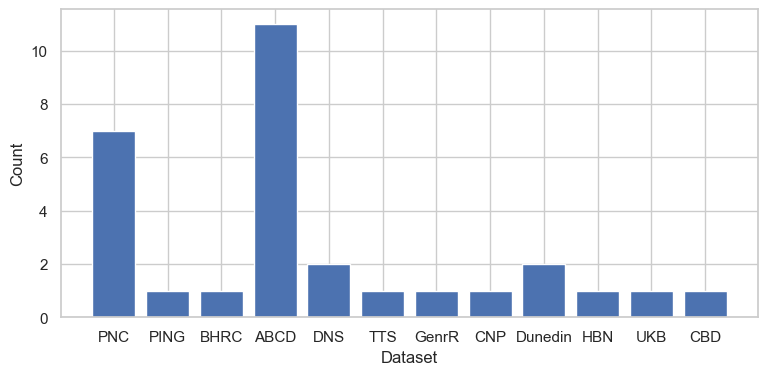

In [19]:

df_datasets = expanded_df.drop_duplicates(subset=['citation', 'dataset'])
# remove rows with nans in p_factor_dims
plt.figure(figsize=(9, 4))
sns.histplot(data=df_datasets, x='dataset', shrink=0.8, alpha = 1)
sns.set_theme(style="whitegrid")
plt.xlabel('Dataset')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('figures/datasets_hist.svg', format = 'svg', dpi=300)

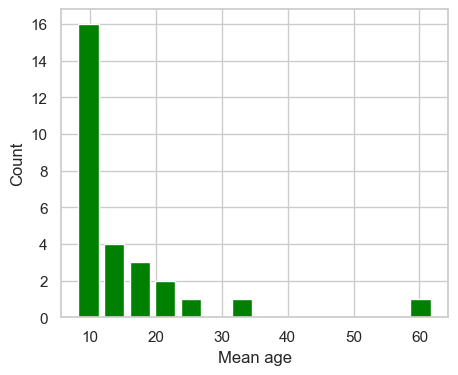

In [20]:
plt.figure(figsize=(5, 4))
sns.histplot(data=df_datasets, x='mean_age', shrink=0.8, alpha = 1, color='green')
sns.set_theme(style="whitegrid")
plt.xlabel('Mean age')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('figures/age_hist.svg', format = 'svg', dpi=300)

## P-factor Methods

In [21]:
assessment_colors = [
    '#4e148c', '#f06900', '#ef476f', '#0080ff', '#fdc500', 
    '#073b4c', '#c77dff', '#017365', '#d00000', '#7e5643', 
    '#b5179e', '#3bceac', "#800000", "#c77dff", "#540fff",
    "#5a622d", "#61173f"
]

In [13]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 4))
df_assessments = expanded_df.drop_duplicates(subset=['citation', 'psy_assessment'])
# Assuming you want to filter out rows where 'p_factor_dims' is literally the string 'nan'

sns.histplot(data=df_assessments, x='psy_assessment', shrink=0.8, alpha=1, hue='psy_assessment', palette=assessment_colors)
sns.set_theme(style="whitegrid")

plt.xlabel('Pscyhopathology Assessments')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format y-axis ticks to be integer
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.savefig('figures/assessment_hist.svg', format = 'svg', dpi=300)

NameError: name 'assessment_colors' is not defined

<Figure size 1000x400 with 0 Axes>

In [15]:
df_assessments['psy_assessment'].unique()

array(['GOASSESS', 'K-SADS-5', 'CBCL', 'MINI', 'MASQ-SF', 'STAI-T',
       'CESD', 'YA-DISC', 'SIPS', 'HSCL', 'ASRS', 'BIS-Brief', 'SCID-I',
       'DIS', 'CBQ', 'MHQ', 'SDQ'], dtype=object)

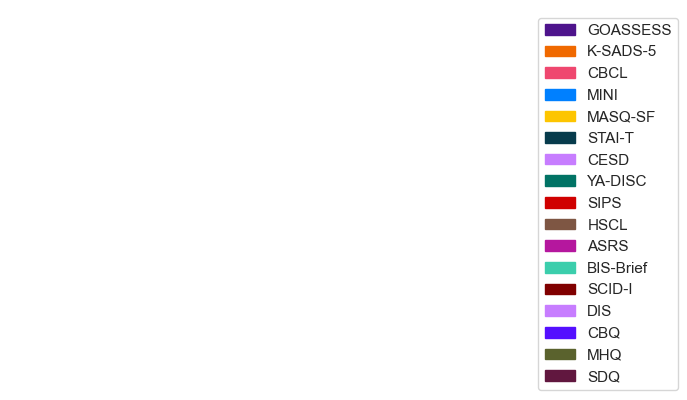

In [23]:
import matplotlib.patches as mpatches

# Define the colors and labels for your legend
colors = sns.color_palette(assessment_colors, len(df_assessments['psy_assessment'].unique()))
labels = df_assessments['psy_assessment'].unique()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Create the legend
fig, ax = plt.subplots()
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the axes
ax.axis('off')

# Show the legend
plt.savefig('figures/assessment_legend.svg', format = 'svg', dpi=300)
plt.show()

In [24]:
p_factor_dims_colors = [
    "#ac2f75",
    "#c043fb",
    "#c36709",
    "#d315f2",
    "#245746",
    "#d8588c",
    "#3ac1e6",
    "#2757ae",
    "#5851a5",
    "#194d48",
    "#099473",
    "#d0f3c5",
    "#fe4faf",
    "#c05263",
    "#d8b1f3",
    "#1d9393",
    "#8ea720",
    "#c109b9",
    "#7f201f",
    "#caf497",
    "#a3fecb",
    "#72b71c",
    "#228080",
    "#a43585"
]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


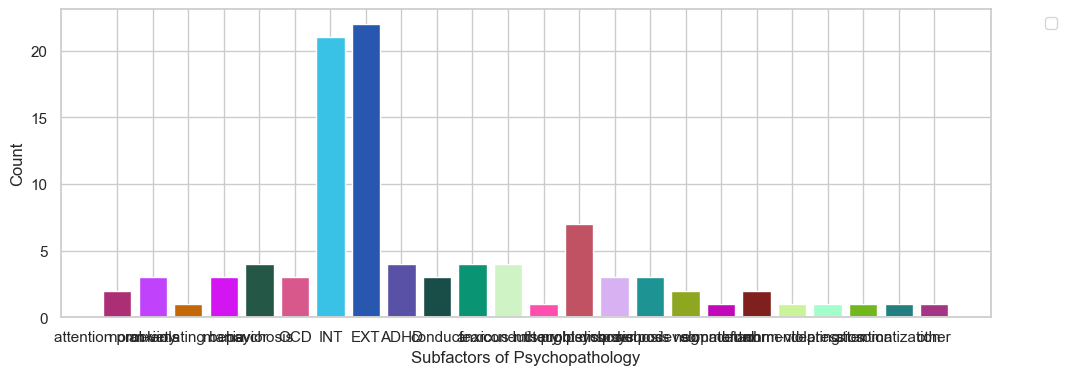

In [25]:

plt.figure(figsize=(12, 4))
df_subfactors = expanded_df.drop_duplicates(subset=['citation', 'p_factor_dims'])
# Assuming you want to filter out rows where 'p_factor_dims' is literally the string 'nan'
df_subfactors = df_subfactors[df_subfactors['p_factor_dims'] != 'nan']

sns.histplot(data=df_subfactors, x='p_factor_dims', shrink=0.8, alpha=1, hue='p_factor_dims', palette=p_factor_dims_colors)
sns.set_theme(style="whitegrid")

plt.xlabel('Subfactors of Psychopathology')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format y-axis ticks to be integer
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.savefig('figures/p_factor_dims_hist.svg', format = 'svg', dpi=300)

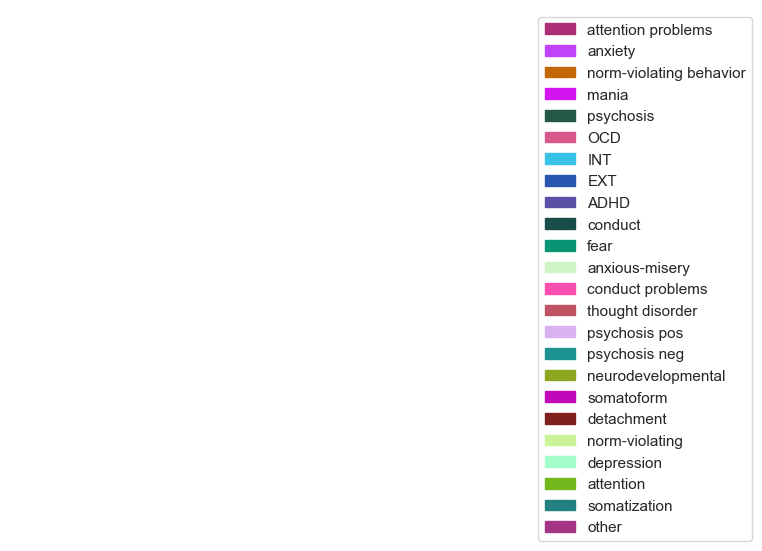

In [26]:
import matplotlib.patches as mpatches

# Define the colors and labels for your legend
colors = sns.color_palette(p_factor_dims_colors, len(df_subfactors['p_factor_dims'].unique()))
labels = df_subfactors['p_factor_dims'].unique()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Create the legend
fig, ax = plt.subplots()
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the axes
ax.axis('off')

# Show the legend
plt.savefig('figures/sp_factor_dims_legend.svg', format = 'svg', dpi=300)
plt.show()


In [27]:
latent_method = expanded_df.drop_duplicates(subset = ["citation", "p_factor_analysis"])


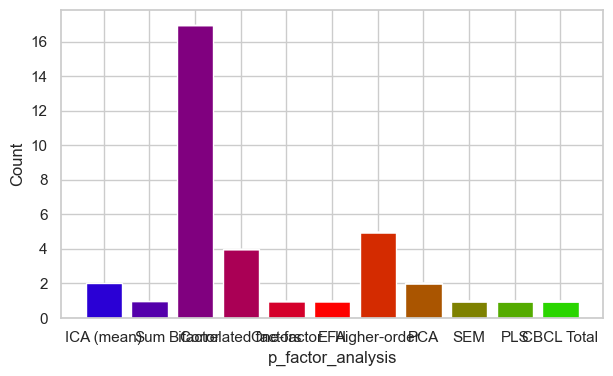

In [28]:
plt.figure(figsize=(7, 4))
sns.histplot(data=latent_method, x='p_factor_analysis', multiple='stack', shrink=0.8, legend=False, hue = 'p_factor_analysis', palette='brg', alpha = 1)
plt.savefig('figures/p_factor_analysis_histplot.svg', format = 'svg', dpi=300)

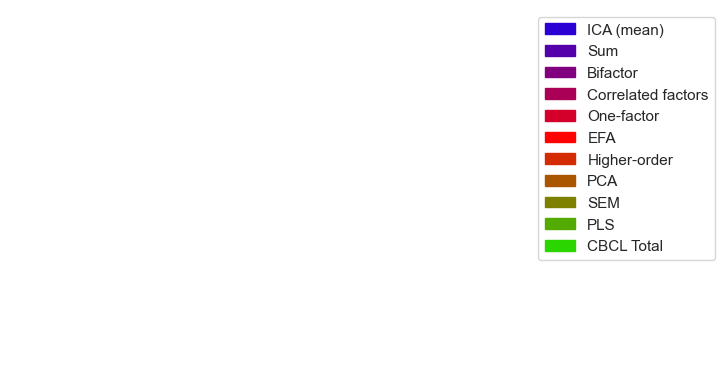

In [29]:
colors = sns.color_palette("brg", len(latent_method['p_factor_analysis'].unique()))
labels = latent_method['p_factor_analysis'].unique()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Create the legend
fig, ax = plt.subplots()
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the axes
ax.axis('off')

# Show the legend
plt.savefig('figures/p_factor_analysis_legend.svg', format = 'svg', dpi=300)
plt.show()

## Effect Sizes

In [30]:
effects_func = expanded_df[expanded_df['biomarker_type'] == 'Functional'][['citation', 'smallest_abs_ef', 'largest_abs_ef']].dropna()
effects_str = expanded_df[expanded_df['biomarker_type'] == 'Structural'][['citation', 'smallest_abs_ef', 'largest_abs_ef']].dropna()


In [31]:
effects_func = effects_func[effects_func["citation"] != "Wang et al. (2023)"] # no sig effects reported for this data modality

In [32]:
effects_func = effects_func.drop_duplicates(subset=['citation', 'smallest_abs_ef', 'largest_abs_ef'])
effects_str = effects_str.drop_duplicates(subset=['citation', 'smallest_abs_ef', 'largest_abs_ef'])

In [33]:
effects_str['biomarker_type'] = 'Structural'
effects_func['biomarker_type'] = 'Functional'
#melt
effects = pd.concat([effects_func, effects_str])
effects = effects.melt(id_vars=['citation', 'biomarker_type'], value_vars=['smallest_abs_ef', 'largest_abs_ef'], var_name='effect_type', value_name='effect_size')

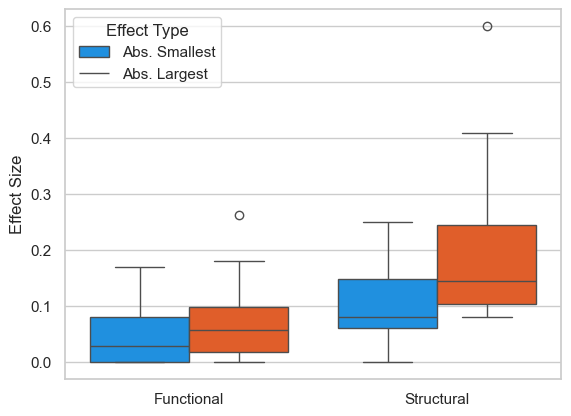

In [34]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=effects, x="biomarker_type", y="effect_size", hue="effect_type", palette = ["#0095ff", "#ff510b"])
ax.set(xlabel="")
ax.set(ylabel="Effect Size")
ax.legend(title='Effect Type', labels=['Abs. Smallest', 'Abs. Largest'])
plt.savefig('figures/effect_size_boxplot.svg', format = 'svg', dpi=300)